## InfoGAN experiments

In [1]:
import utils, torch, time, os, pickle, itertools
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from dataloader import dataloader
import argparse

### Define the network structure of generator
Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)

Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S

In [2]:
class generator(nn.Module):

    def __init__(self, input_dim=100, output_dim=1, input_size=32, len_discrete_code=10, len_continuous_code=2):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.len_discrete_code = len_discrete_code  # categorical distribution (i.e. label)
        self.len_continuous_code = len_continuous_code  # gaussian distribution (e.g. rotation, thickness)

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim + self.len_discrete_code + self.len_continuous_code, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        utils.initialize_weights(self)

    def forward(self, input, cont_code, dist_code):
        x = torch.cat([input, cont_code, dist_code], 1)
        x = self.fc(x)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

### Define the network structure of the discriminator with auxiliary Q network
Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)

Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S

The **Q network** is defined to represent the $q(c|x)$ distribution, which is an approximation of intractable posterior distribution $p(c|x)$.

In [7]:
class discriminator(nn.Module):

    def __init__(self, input_dim=1, output_dim=1, input_size=32, len_discrete_code=10, len_continuous_code=2):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.len_discrete_code = len_discrete_code  # categorical distribution (i.e. label)
        self.len_continuous_code = len_continuous_code  # gaussian distribution (e.g. rotation, thickness)

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim + self.len_continuous_code + self.len_discrete_code),
            # nn.Sigmoid(),
        )
        utils.initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        a = torch.sigmoid(x[:, self.output_dim])
        b = x[:, self.output_dim:self.output_dim + self.len_continuous_code] # Q network for continuous latent code
        c = x[:, self.output_dim + self.len_continuous_code:] # Q network for discrete latent code

        return a, b, c

### Define all methods for infoGAN
Define methods for training process and visilization. 

In [12]:
class infoGAN(object):
    def __init__(self, SUPERVISED=True):
        # parameters
        self.epoch = 50
        self.batch_size = 100
        self.save_dir = 'models'
        self.result_dir = 'results'
        self.dataset = 'mnist'
        self.log_dir = 'logs'
        self.gpu_mode = True
        self.model_name = 'infoGAN'
        self.input_size = 28
        self.z_dim = 62
        self.SUPERVISED = SUPERVISED        # if it is true, label info is directly used for code
        self.len_discrete_code = 10         # categorical distribution (i.e. label)
        self.len_continuous_code = 2        # gaussian distribution (e.g. rotation, thickness)
        self.sample_num = self.len_discrete_code ** 2

        # load dataset
        self.data_loader = dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size, len_discrete_code=self.len_discrete_code, len_continuous_code=self.len_continuous_code)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size, len_discrete_code=self.len_discrete_code, len_continuous_code=self.len_continuous_code)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=1e-3, betas=(0.5, 0.999))
        self.info_optimizer = optim.Adam(itertools.chain(self.G.parameters(), self.D.parameters()), lr=1e-3, betas=(0.5, 0.999))

        if self.gpu_mode:
            self.G.cuda()
            self.D.cuda()
            self.BCE_loss = nn.BCELoss().cuda()
            self.CE_loss = nn.CrossEntropyLoss().cuda()
            self.MSE_loss = nn.MSELoss().cuda()
        else:
            self.BCE_loss = nn.BCELoss()
            self.CE_loss = nn.CrossEntropyLoss()
            self.MSE_loss = nn.MSELoss()

        print('---------- Networks architecture -------------')
        utils.print_network(self.G)
        utils.print_network(self.D)
        print('-----------------------------------------------')

        # fixed noise & condition
        self.sample_z_ = torch.zeros((self.sample_num, self.z_dim))
        for i in range(self.len_discrete_code):
            self.sample_z_[i * self.len_discrete_code] = torch.rand(1, self.z_dim)
            for j in range(1, self.len_discrete_code):
                self.sample_z_[i * self.len_discrete_code + j] = self.sample_z_[i * self.len_discrete_code]

        temp = torch.zeros((self.len_discrete_code, 1))
        for i in range(self.len_discrete_code):
            temp[i, 0] = i

        temp_y = torch.zeros((self.sample_num, 1))
        for i in range(self.len_discrete_code):
            temp_y[i * self.len_discrete_code: (i + 1) * self.len_discrete_code] = temp

        self.sample_y_ = torch.zeros((self.sample_num, self.len_discrete_code)).scatter_(1, temp_y.type(torch.LongTensor), 1)
        self.sample_c_ = torch.zeros((self.sample_num, self.len_continuous_code))

        # manipulating two continuous code
        self.sample_z2_ = torch.rand((1, self.z_dim)).expand(self.sample_num, self.z_dim)
        self.sample_y2_ = torch.zeros(self.sample_num, self.len_discrete_code)
        self.sample_y2_[:, 0] = 1

        temp_c = torch.linspace(-1, 1, 10)
        self.sample_c2_ = torch.zeros((self.sample_num, 2))
        for i in range(self.len_discrete_code):
            for j in range(self.len_discrete_code):
                self.sample_c2_[i*self.len_discrete_code+j, 0] = temp_c[i]
                self.sample_c2_[i*self.len_discrete_code+j, 1] = temp_c[j]

        if self.gpu_mode:
            self.sample_z_, self.sample_y_, self.sample_c_, self.sample_z2_, self.sample_y2_, self.sample_c2_ = \
                self.sample_z_.cuda(), self.sample_y_.cuda(), self.sample_c_.cuda(), self.sample_z2_.cuda(), \
                self.sample_y2_.cuda(), self.sample_c2_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['info_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size), torch.zeros(self.batch_size)
        if self.gpu_mode:
            self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        print('training start!!')
        start_time = time.time()
        for epoch in range(self.epoch):
            self.G.train()
            epoch_start_time = time.time()
            for iter, (x_, y_) in enumerate(self.data_loader):
                
                z_ = torch.rand((self.batch_size, self.z_dim))
                if self.SUPERVISED:
                    y_disc_ = torch.zeros((self.batch_size, self.len_discrete_code)).scatter_(1, y_.type(torch.LongTensor).unsqueeze(1), 1)
                else:
                    y_disc_ = torch.from_numpy(
                        np.random.multinomial(1, self.len_discrete_code * [float(1.0 / self.len_discrete_code)],
                                              size=[self.batch_size])).type(torch.FloatTensor)

                y_cont_ = torch.from_numpy(np.random.uniform(-1, 1, size=(self.batch_size, 2))).type(torch.FloatTensor)

                if self.gpu_mode:
                    x_, z_, y_disc_, y_cont_ = x_.cuda(), z_.cuda(), y_disc_.cuda(), y_cont_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real, _, D_disc = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)
                if self.SUPERVISED:
                    D_real_loss += self.CE_loss(D_disc, torch.max(y_disc_, 1)[1])

                G_ = self.G(z_, y_cont_, y_disc_)
                D_fake, _, D_disc = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)
                if self.SUPERVISED:
                    D_fake_loss += self.CE_loss(D_disc, torch.max(y_disc_, 1)[1])

                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward(retain_graph=True)
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_, y_cont_, y_disc_)
                D_fake, D_cont, D_disc = self.D(G_)

                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward(retain_graph=True)
                self.G_optimizer.step()

                # information loss
                disc_loss = self.CE_loss(D_disc, torch.max(y_disc_, 1)[1])
                cont_loss = self.MSE_loss(D_cont, y_cont_)
                info_loss = disc_loss + cont_loss
                self.train_hist['info_loss'].append(info_loss.item())

                info_loss.backward()
                self.info_optimizer.step()


                if ((iter + 1) % 100) == 0:
                    print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f, info_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item(), info_loss.item()))

            self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
            with torch.no_grad():
                self.visualize_results((epoch+1))

        self.train_hist['total_time'].append(time.time() - start_time)
        print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
                                                                        self.epoch, self.train_hist['total_time'][0]))
        print("Training finish!... save training results")

        self.save()
        utils.generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        utils.generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_cont',
                                 self.epoch)
        self.loss_plot(self.train_hist, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)

    def visualize_results(self, epoch):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        image_frame_dim = int(np.floor(np.sqrt(self.sample_num)))

        """ style by class """
        samples = self.G(self.sample_z_, self.sample_c_, self.sample_y_)
        if self.gpu_mode:
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        
        if epoch == 1 or epoch % 10 == 0:
            print(f"Generated images: Style by class at epoch {epoch}")
            utils.show_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim])
        
        utils.save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')

        """ manipulating two continous codes """
        samples = self.G(self.sample_z2_, self.sample_c2_, self.sample_y2_)
        if self.gpu_mode:
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        
        if epoch == 1 or epoch % 10 == 0:
            print(f"Generated images: Manipulating two continous codes at epoch {epoch}")
            utils.show_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim])

        utils.save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_cont_epoch%03d' % epoch + '.png')

    def save(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))

        with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)

    def load(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))

    def loss_plot(self, hist, path='Train_hist.png', model_name=''):
        x = range(len(hist['D_loss']))

        y1 = hist['D_loss']
        y2 = hist['G_loss']
        y3 = hist['info_loss']

        plt.plot(x, y1, label='D_loss')
        plt.plot(x, y2, label='G_loss')
        plt.plot(x, y3, label='info_loss')

        plt.xlabel('Iter')
        plt.ylabel('Loss')

        plt.legend(loc=4)
        plt.grid(True)
        plt.tight_layout()

        path = os.path.join(path, model_name + '_loss.png')

        plt.savefig(path)

In [5]:
torch.backends.cudnn.benchmark = True

# declare instance for GAN
gan = infoGAN(SUPERVISED=False)

---------- Networks architecture -------------
generator(
  (fc): Sequential(
    (0): Linear(in_features=74, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)
Total number of parameters: 6652481
discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

## Start training without catagorical supervision
We visulize the generated image after the first epoch and each 10 epochs.

training start!!
Epoch: [ 1] [ 100/ 600] D_loss: 1.04927313, G_loss: 0.84700704, info_loss: 0.33007458
Epoch: [ 1] [ 200/ 600] D_loss: 1.11762536, G_loss: 1.00214815, info_loss: 0.57676631
Epoch: [ 1] [ 300/ 600] D_loss: 1.22827065, G_loss: 0.87532610, info_loss: 0.21940526
Epoch: [ 1] [ 400/ 600] D_loss: 1.27560651, G_loss: 0.80685693, info_loss: 0.19604152
Epoch: [ 1] [ 500/ 600] D_loss: 1.24005306, G_loss: 0.78462380, info_loss: 0.14608282
Epoch: [ 1] [ 600/ 600] D_loss: 1.23486233, G_loss: 0.84448028, info_loss: 0.15868363
Generated images: Style by class at epoch 1


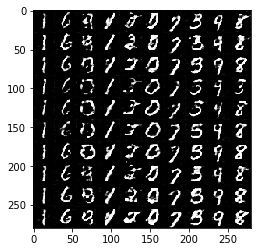

Generated images: Manipulating two continous codes at epoch 1


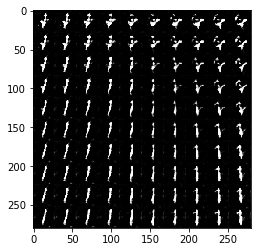

Epoch: [ 2] [ 100/ 600] D_loss: 1.25149810, G_loss: 0.86386687, info_loss: 0.15464805
Epoch: [ 2] [ 200/ 600] D_loss: 1.28696597, G_loss: 0.79263860, info_loss: 0.18615054
Epoch: [ 2] [ 300/ 600] D_loss: 1.27812099, G_loss: 0.79017359, info_loss: 0.17105813
Epoch: [ 2] [ 400/ 600] D_loss: 1.29620445, G_loss: 0.76885092, info_loss: 0.11507622
Epoch: [ 2] [ 500/ 600] D_loss: 1.28362513, G_loss: 0.82636046, info_loss: 0.15777171
Epoch: [ 2] [ 600/ 600] D_loss: 1.28921092, G_loss: 0.76534384, info_loss: 0.11924553
Epoch: [ 3] [ 100/ 600] D_loss: 1.31128860, G_loss: 0.76254541, info_loss: 0.15681340
Epoch: [ 3] [ 200/ 600] D_loss: 1.28011012, G_loss: 0.79289103, info_loss: 0.13333885
Epoch: [ 3] [ 300/ 600] D_loss: 1.32168591, G_loss: 0.74898559, info_loss: 0.08856247
Epoch: [ 3] [ 400/ 600] D_loss: 1.28884113, G_loss: 0.77653122, info_loss: 0.08236048
Epoch: [ 3] [ 500/ 600] D_loss: 1.33430719, G_loss: 0.77621543, info_loss: 0.12184018
Epoch: [ 3] [ 600/ 600] D_loss: 1.32206368, G_loss: 0.

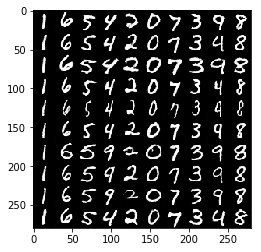

Generated images: Manipulating two continous codes at epoch 10


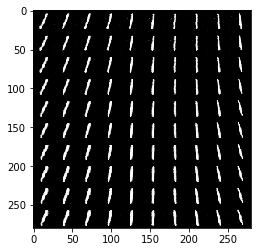

Epoch: [11] [ 100/ 600] D_loss: 1.35777009, G_loss: 0.73410529, info_loss: 0.10181173
Epoch: [11] [ 200/ 600] D_loss: 1.35905504, G_loss: 0.74823552, info_loss: 0.10015199
Epoch: [11] [ 300/ 600] D_loss: 1.31310093, G_loss: 0.77234197, info_loss: 0.09068435
Epoch: [11] [ 400/ 600] D_loss: 1.31645644, G_loss: 0.76821786, info_loss: 0.07301991
Epoch: [11] [ 500/ 600] D_loss: 1.32479894, G_loss: 0.77489924, info_loss: 0.11057893
Epoch: [11] [ 600/ 600] D_loss: 1.35055697, G_loss: 0.72240067, info_loss: 0.09043388
Epoch: [12] [ 100/ 600] D_loss: 1.33718026, G_loss: 0.73852921, info_loss: 0.13989833
Epoch: [12] [ 200/ 600] D_loss: 1.34796906, G_loss: 0.75954896, info_loss: 0.14814791
Epoch: [12] [ 300/ 600] D_loss: 1.30164647, G_loss: 0.77885526, info_loss: 0.10071360
Epoch: [12] [ 400/ 600] D_loss: 1.34223986, G_loss: 0.74218279, info_loss: 0.15275618
Epoch: [12] [ 500/ 600] D_loss: 1.33080995, G_loss: 0.75488108, info_loss: 0.11141372
Epoch: [12] [ 600/ 600] D_loss: 1.30902171, G_loss: 0.

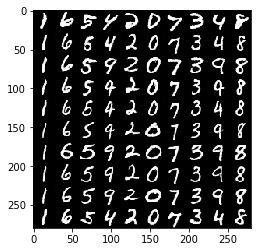

Generated images: Manipulating two continous codes at epoch 20


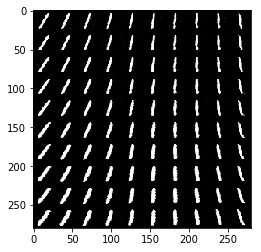

Epoch: [21] [ 100/ 600] D_loss: 1.33971763, G_loss: 0.76282394, info_loss: 0.10977786
Epoch: [21] [ 200/ 600] D_loss: 1.32384849, G_loss: 0.79005569, info_loss: 0.08487429
Epoch: [21] [ 300/ 600] D_loss: 1.34834993, G_loss: 0.75709939, info_loss: 0.14916261
Epoch: [21] [ 400/ 600] D_loss: 1.32406306, G_loss: 0.80075473, info_loss: 0.13438912
Epoch: [21] [ 500/ 600] D_loss: 1.32984698, G_loss: 0.75049508, info_loss: 0.11530011
Epoch: [21] [ 600/ 600] D_loss: 1.28247654, G_loss: 0.81324852, info_loss: 0.13903396
Epoch: [22] [ 100/ 600] D_loss: 1.31053209, G_loss: 0.78476524, info_loss: 0.13460174
Epoch: [22] [ 200/ 600] D_loss: 1.32731092, G_loss: 0.78978533, info_loss: 0.11747698
Epoch: [22] [ 300/ 600] D_loss: 1.29889143, G_loss: 0.78195608, info_loss: 0.10430814
Epoch: [22] [ 400/ 600] D_loss: 1.26310921, G_loss: 0.81634349, info_loss: 0.15252593
Epoch: [22] [ 500/ 600] D_loss: 1.32304144, G_loss: 0.80121976, info_loss: 0.09198973
Epoch: [22] [ 600/ 600] D_loss: 1.30106783, G_loss: 0.

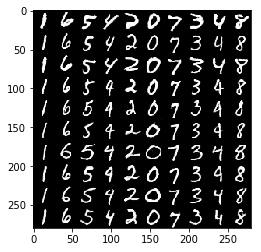

Generated images: Manipulating two continous codes at epoch 30


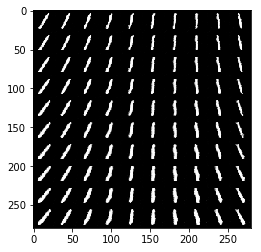

Epoch: [31] [ 100/ 600] D_loss: 1.34361565, G_loss: 0.81902444, info_loss: 0.13974324
Epoch: [31] [ 200/ 600] D_loss: 1.31860411, G_loss: 0.82821566, info_loss: 0.13737744
Epoch: [31] [ 300/ 600] D_loss: 1.34523439, G_loss: 0.82123512, info_loss: 0.11478982
Epoch: [31] [ 400/ 600] D_loss: 1.28882086, G_loss: 0.82037771, info_loss: 0.15826832
Epoch: [31] [ 500/ 600] D_loss: 1.29835200, G_loss: 0.79967344, info_loss: 0.17561151
Epoch: [31] [ 600/ 600] D_loss: 1.31222928, G_loss: 0.82298827, info_loss: 0.12058764
Epoch: [32] [ 100/ 600] D_loss: 1.30776846, G_loss: 0.83560240, info_loss: 0.11549032
Epoch: [32] [ 200/ 600] D_loss: 1.31390882, G_loss: 0.81371379, info_loss: 0.14176761
Epoch: [32] [ 300/ 600] D_loss: 1.35473919, G_loss: 0.74841058, info_loss: 0.16017528
Epoch: [32] [ 400/ 600] D_loss: 1.31359911, G_loss: 0.80233574, info_loss: 0.13828315
Epoch: [32] [ 500/ 600] D_loss: 1.36999130, G_loss: 0.78793871, info_loss: 0.17011602
Epoch: [32] [ 600/ 600] D_loss: 1.37273240, G_loss: 0.

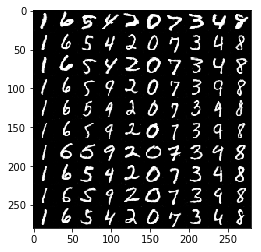

Generated images: Manipulating two continous codes at epoch 40


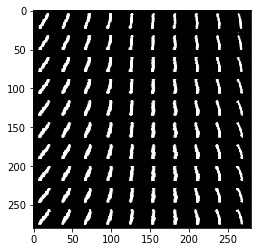

Epoch: [41] [ 100/ 600] D_loss: 1.28789806, G_loss: 0.85510772, info_loss: 0.12849309
Epoch: [41] [ 200/ 600] D_loss: 1.27959180, G_loss: 0.82976586, info_loss: 0.18635687
Epoch: [41] [ 300/ 600] D_loss: 1.29973221, G_loss: 0.84421921, info_loss: 0.14743765
Epoch: [41] [ 400/ 600] D_loss: 1.30809796, G_loss: 0.81989813, info_loss: 0.14042591
Epoch: [41] [ 500/ 600] D_loss: 1.30297005, G_loss: 0.82148200, info_loss: 0.16482787
Epoch: [41] [ 600/ 600] D_loss: 1.35693049, G_loss: 0.84398723, info_loss: 0.14770299
Epoch: [42] [ 100/ 600] D_loss: 1.30136061, G_loss: 0.82437265, info_loss: 0.13609339
Epoch: [42] [ 200/ 600] D_loss: 1.26030123, G_loss: 0.87229162, info_loss: 0.17494814
Epoch: [42] [ 300/ 600] D_loss: 1.31110036, G_loss: 0.82477874, info_loss: 0.19511831
Epoch: [42] [ 400/ 600] D_loss: 1.29288435, G_loss: 0.83462995, info_loss: 0.17839776
Epoch: [42] [ 500/ 600] D_loss: 1.34484422, G_loss: 0.86048651, info_loss: 0.21524192
Epoch: [42] [ 600/ 600] D_loss: 1.25821996, G_loss: 0.

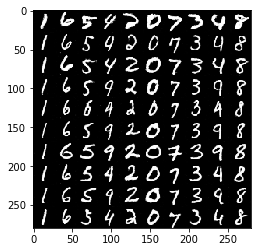

Generated images: Manipulating two continous codes at epoch 50


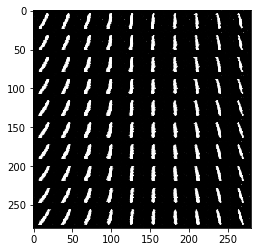

Avg one epoch time: 16.44, total 50 epochs time: 824.24
Training finish!... save training results
 [*] Training finished!


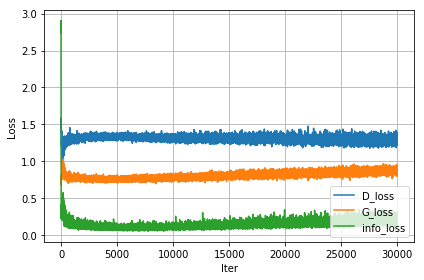

In [6]:
# launch the graph in a session
gan.train()
print(" [*] Training finished!")

### Analysis of the results (unsupervised training for catagorical codes)
We can see that the quality of generated images becomes better as epochs go on.

For the "Style by class" image, each row represents the images generated from the same latent code.

For the "Manipulating two continous codes" image, items in each row represent the images by changing the **first** continuous code which controls the **angle** while images at each column are generated by changing the **second** continuous code which controls the **thickness**.

Since in this experiment, the catagorical latent codes are trained without supervision by its real class information,
therefore the order of the latent catagoical codes does not match the order of the generated number images, i.e., the second latent code $[0,1,0,\cdots, 0 ]$ does not generate the image of number '1'.
However, the same catagorical latent code is always generating the same number consistently at each epoch.

### GIF Visulization for generated images during the training process
The first one is "Style by class".
![style-by-class](results/mnist/infoGAN/unsupervise_infoGAN_generate_animation.gif "Style by class")
and the second one is "Manipulating two continous codes".
![cont-codes](results/mnist/infoGAN/unsupervise_infoGAN_cont_generate_animation.gif "Manipulating two continous codes")

## Start training with catagorical supervision
In this section, we show the training process with supervision on classes of iamges.
First, we directly use the label of real image as the catagorical latent code
and we **add** cross entrophy loss to train the discriminator so that it could classify the images not only for real or fake but also for the **10 classes**.

In this way, the discriminator as well as infomation loss can force the generator to produce images for **certain classes**.

In [13]:
# declare instance for GAN
gan = infoGAN(SUPERVISED=True)

---------- Networks architecture -------------
generator(
  (fc): Sequential(
    (0): Linear(in_features=74, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)
Total number of parameters: 6652481
discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

training start!!
Epoch: [ 1] [ 100/ 600] D_loss: 1.44033480, G_loss: 0.71074033, info_loss: 0.10470451
Epoch: [ 1] [ 200/ 600] D_loss: 1.60009861, G_loss: 0.75278831, info_loss: 0.08370978
Epoch: [ 1] [ 300/ 600] D_loss: 1.46438551, G_loss: 0.72827530, info_loss: 0.07169387
Epoch: [ 1] [ 400/ 600] D_loss: 1.41422594, G_loss: 0.74630219, info_loss: 0.06476896
Epoch: [ 1] [ 500/ 600] D_loss: 1.47853613, G_loss: 0.68001860, info_loss: 0.10822058
Epoch: [ 1] [ 600/ 600] D_loss: 1.46538687, G_loss: 0.70991552, info_loss: 0.05565188
Generated images: Style by class at epoch 1


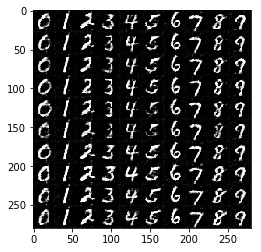

Generated images: Manipulating two continous codes at epoch 1


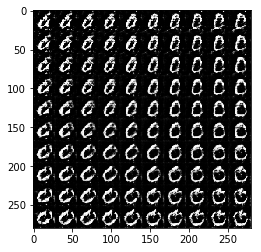

Epoch: [ 2] [ 100/ 600] D_loss: 1.40783072, G_loss: 0.68285751, info_loss: 0.08191972
Epoch: [ 2] [ 200/ 600] D_loss: 1.48091483, G_loss: 0.69270837, info_loss: 0.09670131
Epoch: [ 2] [ 300/ 600] D_loss: 1.33096743, G_loss: 0.73359352, info_loss: 0.07661272
Epoch: [ 2] [ 400/ 600] D_loss: 1.40258908, G_loss: 0.68067199, info_loss: 0.07585152
Epoch: [ 2] [ 500/ 600] D_loss: 1.41633725, G_loss: 0.69869238, info_loss: 0.06679022
Epoch: [ 2] [ 600/ 600] D_loss: 1.52168012, G_loss: 0.68537158, info_loss: 0.08194974
Epoch: [ 3] [ 100/ 600] D_loss: 1.38297582, G_loss: 0.69249451, info_loss: 0.06835662
Epoch: [ 3] [ 200/ 600] D_loss: 1.40789056, G_loss: 0.70727181, info_loss: 0.06311800
Epoch: [ 3] [ 300/ 600] D_loss: 1.38569558, G_loss: 0.72682983, info_loss: 0.05858688
Epoch: [ 3] [ 400/ 600] D_loss: 1.39000034, G_loss: 0.71073335, info_loss: 0.07331059
Epoch: [ 3] [ 500/ 600] D_loss: 1.39443827, G_loss: 0.69836634, info_loss: 0.07401461
Epoch: [ 3] [ 600/ 600] D_loss: 1.41756380, G_loss: 0.

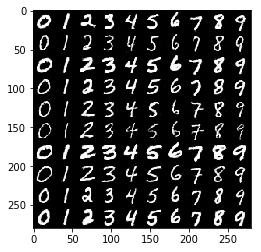

Generated images: Manipulating two continous codes at epoch 10


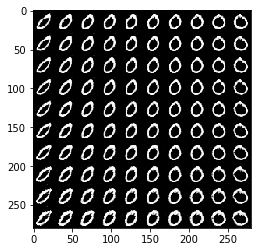

Epoch: [11] [ 100/ 600] D_loss: 1.34987772, G_loss: 0.71348786, info_loss: 0.04897131
Epoch: [11] [ 200/ 600] D_loss: 1.35959828, G_loss: 0.68808103, info_loss: 0.05124083
Epoch: [11] [ 300/ 600] D_loss: 1.35452247, G_loss: 0.69595748, info_loss: 0.07546975
Epoch: [11] [ 400/ 600] D_loss: 1.38772523, G_loss: 0.68403655, info_loss: 0.05660026
Epoch: [11] [ 500/ 600] D_loss: 1.35388529, G_loss: 0.67228806, info_loss: 0.05914958
Epoch: [11] [ 600/ 600] D_loss: 1.36017323, G_loss: 0.68153673, info_loss: 0.08609915
Epoch: [12] [ 100/ 600] D_loss: 1.36856639, G_loss: 0.67674822, info_loss: 0.07261235
Epoch: [12] [ 200/ 600] D_loss: 1.34999156, G_loss: 0.69132996, info_loss: 0.06028243
Epoch: [12] [ 300/ 600] D_loss: 1.36684489, G_loss: 0.66673934, info_loss: 0.05795281
Epoch: [12] [ 400/ 600] D_loss: 1.36685467, G_loss: 0.69947952, info_loss: 0.05947063
Epoch: [12] [ 500/ 600] D_loss: 1.40289092, G_loss: 0.72620583, info_loss: 0.05278568
Epoch: [12] [ 600/ 600] D_loss: 1.38255537, G_loss: 0.

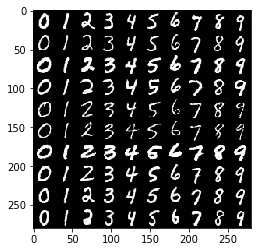

Generated images: Manipulating two continous codes at epoch 20


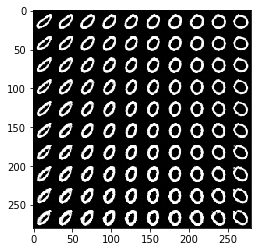

Epoch: [21] [ 100/ 600] D_loss: 1.32549536, G_loss: 0.71956724, info_loss: 0.05241709
Epoch: [21] [ 200/ 600] D_loss: 1.32137895, G_loss: 0.70355803, info_loss: 0.04874040
Epoch: [21] [ 300/ 600] D_loss: 1.30744886, G_loss: 0.74311137, info_loss: 0.04934435
Epoch: [21] [ 400/ 600] D_loss: 1.33161449, G_loss: 0.72531420, info_loss: 0.04551616
Epoch: [21] [ 500/ 600] D_loss: 1.31337607, G_loss: 0.72195977, info_loss: 0.06957099
Epoch: [21] [ 600/ 600] D_loss: 1.31369913, G_loss: 0.73954934, info_loss: 0.05998974
Epoch: [22] [ 100/ 600] D_loss: 1.34608030, G_loss: 0.72960854, info_loss: 0.06277937
Epoch: [22] [ 200/ 600] D_loss: 1.31868362, G_loss: 0.70947832, info_loss: 0.07309610
Epoch: [22] [ 300/ 600] D_loss: 1.31548810, G_loss: 0.72025108, info_loss: 0.08325892
Epoch: [22] [ 400/ 600] D_loss: 1.32589769, G_loss: 0.69383448, info_loss: 0.05661617
Epoch: [22] [ 500/ 600] D_loss: 1.31969857, G_loss: 0.72424483, info_loss: 0.06404652
Epoch: [22] [ 600/ 600] D_loss: 1.33801472, G_loss: 0.

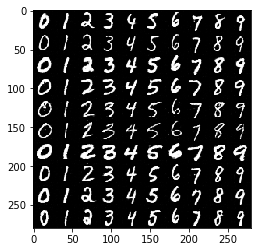

Generated images: Manipulating two continous codes at epoch 30


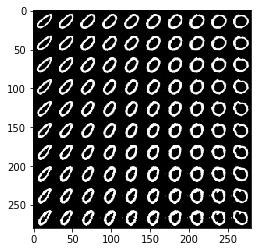

Epoch: [31] [ 100/ 600] D_loss: 1.33691502, G_loss: 0.70868003, info_loss: 0.07418454
Epoch: [31] [ 200/ 600] D_loss: 1.36045289, G_loss: 0.72126883, info_loss: 0.07133395
Epoch: [31] [ 300/ 600] D_loss: 1.30598438, G_loss: 0.74838740, info_loss: 0.07449425
Epoch: [31] [ 400/ 600] D_loss: 1.30026364, G_loss: 0.73413873, info_loss: 0.09547319
Epoch: [31] [ 500/ 600] D_loss: 1.31342649, G_loss: 0.73512191, info_loss: 0.07198231
Epoch: [31] [ 600/ 600] D_loss: 1.30206847, G_loss: 0.76775366, info_loss: 0.08563010
Epoch: [32] [ 100/ 600] D_loss: 1.33795190, G_loss: 0.71903419, info_loss: 0.07079112
Epoch: [32] [ 200/ 600] D_loss: 1.30791044, G_loss: 0.72464919, info_loss: 0.07652865
Epoch: [32] [ 300/ 600] D_loss: 1.30114174, G_loss: 0.73571229, info_loss: 0.07314373
Epoch: [32] [ 400/ 600] D_loss: 1.33033967, G_loss: 0.74103773, info_loss: 0.08746447
Epoch: [32] [ 500/ 600] D_loss: 1.33659959, G_loss: 0.69621664, info_loss: 0.09139685
Epoch: [32] [ 600/ 600] D_loss: 1.34645820, G_loss: 0.

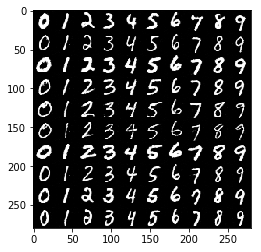

Generated images: Manipulating two continous codes at epoch 40


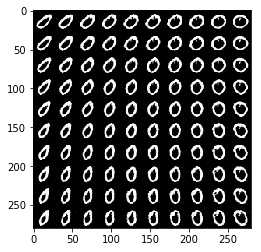

Epoch: [41] [ 100/ 600] D_loss: 1.29162633, G_loss: 0.76504189, info_loss: 0.08802092
Epoch: [41] [ 200/ 600] D_loss: 1.31155562, G_loss: 0.72398651, info_loss: 0.12316119
Epoch: [41] [ 300/ 600] D_loss: 1.35203123, G_loss: 0.73043603, info_loss: 0.06573776
Epoch: [41] [ 400/ 600] D_loss: 1.30498314, G_loss: 0.75522059, info_loss: 0.09170872
Epoch: [41] [ 500/ 600] D_loss: 1.31814897, G_loss: 0.72980750, info_loss: 0.09456896
Epoch: [41] [ 600/ 600] D_loss: 1.33345628, G_loss: 0.74157488, info_loss: 0.07393604
Epoch: [42] [ 100/ 600] D_loss: 1.29543054, G_loss: 0.75509447, info_loss: 0.07269732
Epoch: [42] [ 200/ 600] D_loss: 1.37655699, G_loss: 0.74596161, info_loss: 0.10407794
Epoch: [42] [ 300/ 600] D_loss: 1.28947771, G_loss: 0.75411171, info_loss: 0.08908927
Epoch: [42] [ 400/ 600] D_loss: 1.28792429, G_loss: 0.76330394, info_loss: 0.07993902
Epoch: [42] [ 500/ 600] D_loss: 1.32846105, G_loss: 0.73227125, info_loss: 0.05969713
Epoch: [42] [ 600/ 600] D_loss: 1.31642973, G_loss: 0.

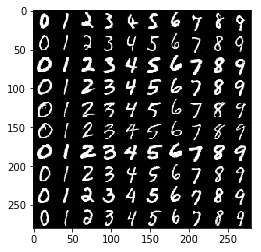

Generated images: Manipulating two continous codes at epoch 50


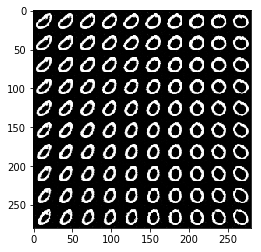

Avg one epoch time: 16.75, total 50 epochs time: 840.29
Training finish!... save training results
 [*] Training finished!


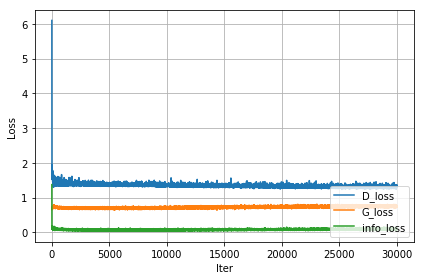

In [14]:
# launch the graph in a session
gan.train()
print(" [*] Training finished!")

### GIF Visulization for generated images during the training process
The first one is "Style by class".
![style-by-class](results/mnist/infoGAN/supervise_infoGAN_generate_animation.gif "Style by class")
and the second one is "Manipulating two continous codes".
![cont-codes](results/mnist/infoGAN/supervise_infoGAN_cont_generate_animation.gif "Manipulating two continous codes")

We can see that with supervision on the catagorical latent code, we can control which number image to be generated.